In [2]:
# Crop Pest and Disease Detection - Group Preprocessing Pipeline
# ============================================================================
# This notebook combines all preprocessing steps (Member 1 → Member 6).
# - Only one input_path (raw data) and one output_path (processed data).
# - Each step overwrites data inside the same output folder to save space.
# - Steps are kept in the same order with clear headers and explanations.
# ============================================================================

# --- Common Imports ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

# Define single input/output paths
input_path = "C:\\Users\\CYBORG 15\\Desktop\\maize Crop Pest and Disease Detection\\original unzipped data set"        # Raw dataset folder
output_path = "C:\\Users\\CYBORG 15\\Desktop\\testing1 preprocesseed" # Final preprocessed dataset folder
os.makedirs(output_path, exist_ok=True)

Step 1: Handling corrupt images...
Class 'Maize fall armyworm': Removed 0 corrupt images
Class 'Maize grasshoper': Removed 0 corrupt images
Class 'Maize healthy': Removed 4 corrupt images
Class 'Maize leaf beetle': Removed 15 corrupt images
Class 'Maize leaf blight': Removed 16 corrupt images
Class 'Maize leaf spot': Removed 20 corrupt images
Class 'Maize streak virus': Removed 14 corrupt images


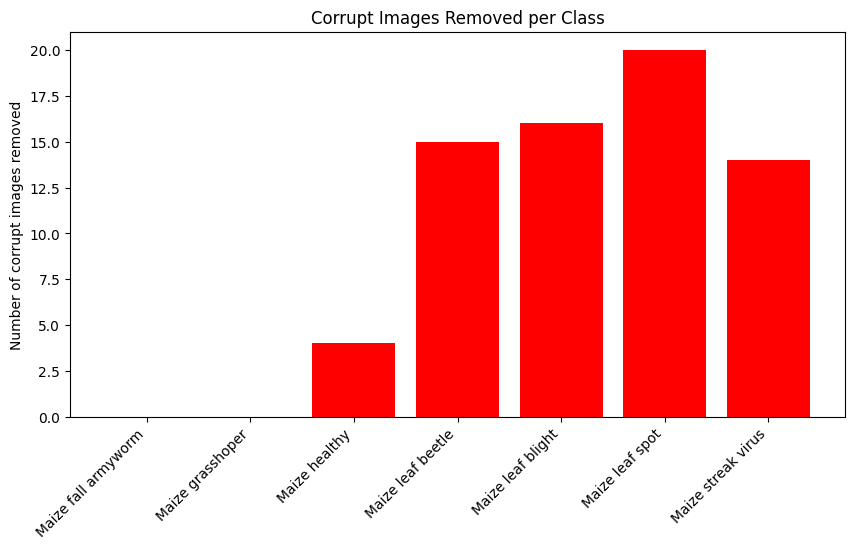

In [3]:
#IT24103011 – Handling Missing / Corrupt Images
# ============================================================================
print("Step 1: Handling corrupt images...")

corrupt_count_per_class = {}
class_folders = [f for f in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, f))]

for class_name in class_folders:
    class_path = os.path.join(input_path, class_name)
    output_class_path = os.path.join(output_path, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    corrupt_images = []
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()                     # Verify integrity
            img = Image.open(img_path).convert("RGB")
            img.save(os.path.join(output_class_path, img_file))  # Save clean copy
        except (IOError, SyntaxError):
            corrupt_images.append(img_file)

    corrupt_count_per_class[class_name] = len(corrupt_images)
    print(f"Class '{class_name}': Removed {len(corrupt_images)} corrupt images")

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(corrupt_count_per_class.keys(), corrupt_count_per_class.values(), color="red")
plt.ylabel("Number of corrupt images removed")
plt.title("Corrupt Images Removed per Class")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
# IT24103426 – Image Resizing
# ============================================================================
print("Step 2: Resizing images...")

TARGET_SIZE = (128, 128)
original_sizes = []
class_counts_m2 = {}

for class_name in class_folders:
    class_path = os.path.join(output_path, class_name)  # Work in same folder
    count = 0
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            original_sizes.append(img.size)
            img_resized = img.resize(TARGET_SIZE)
            img_resized.save(img_path)  # Overwrite resized image
            count += 1
        except Exception as e:
            print(f"Error resizing {img_file}: {e}")
    class_counts_m2[class_name] = count
    print(f"Class '{class_name}': Resized {count} images")

# Visualization
widths, heights = zip(*original_sizes)
plt.figure(figsize=(10, 5))
plt.scatter(widths, heights, alpha=0.5, color="blue")
plt.title("Original Image Dimensions")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(class_counts_m2.keys(), class_counts_m2.values(), color="green")
plt.title("Resized Images per Class")
plt.xticks(rotation=45, ha="right")
plt.show()

Step 2: Resizing images...
Class 'Maize fall armyworm': Resized 285 images
Class 'Maize grasshoper': Resized 673 images
Class 'Maize healthy': Resized 204 images
Class 'Maize leaf beetle': Resized 933 images
Class 'Maize leaf blight': Resized 990 images


In [ ]:
# IT24103358 – Normalization / Scaling
# ============================================================================
print("Step 3: Normalizing images...")

orig_hist = np.zeros(256)
norm_hist = np.zeros(100)
class_counts_m3 = {}

for class_name in class_folders:
    class_path = os.path.join(output_path, class_name)
    count = 0
    for img_file in os.listdir(class_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist, _ = np.histogram(img, bins=256, range=(0, 255))
        orig_hist += hist
        normalized_img = img / 255.0
        hist, _ = np.histogram(normalized_img, bins=100, range=(0, 1))
        norm_hist += hist
        normalized_uint8 = (normalized_img * 255).astype(np.uint8)
        cv2.imwrite(img_path, cv2.cvtColor(normalized_uint8, cv2.COLOR_RGB2BGR))
        count += 1
    class_counts_m3[class_name] = count
    print(f"Class '{class_name}': Normalized {count} images")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(256), orig_hist, color="orange")
plt.title("Original Pixel Intensities")

plt.subplot(1, 2, 2)
plt.bar(np.linspace(0, 1, 100), norm_hist, width=0.01, color="green")
plt.title("Normalized Pixel Intensities")
plt.tight_layout()
plt.show()

In [ ]:
# IT24103044 – Outlier Removal
# ============================================================================
print("Step 4: Removing outliers...")

class_valid_counts = {}
class_outlier_counts = {}
brightness_means = []

for class_name in class_folders:
    class_path = os.path.join(output_path, class_name)
    valid_count = 0
    outlier_count = 0
    for img_file in os.listdir(class_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            outlier_count += 1
            os.remove(img_path)   # Delete outlier
            continue
        h, w, _ = img.shape
        if h < 50 or w < 50:      # Too small images
            outlier_count += 1
            os.remove(img_path)
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean_brightness = np.mean(gray)
        brightness_means.append(mean_brightness)
        if mean_brightness < 20 or mean_brightness > 235:
            outlier_count += 1
            os.remove(img_path)
            continue
        valid_count += 1
    class_valid_counts[class_name] = valid_count
    class_outlier_counts[class_name] = outlier_count

# Visualization
plt.figure(figsize=(8, 5))
plt.hist(brightness_means, bins=50, color="purple")
plt.title("Brightness Distribution")
plt.show()

In [ ]:
# IT24103179 – Feature Engineering (PCA)
# ============================================================================
print("Step 5: Applying PCA...")

X, y, class_names = [], [], []

for class_name in class_folders:
    class_path = os.path.join(output_path, class_name)
    class_names.append(class_name)
    for img_file in os.listdir(class_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img = cv2.imread(os.path.join(class_path, img_file), cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        X.append(img.flatten())
        y.append(class_name)

X = np.array(X)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Explained Variance by PCA")
plt.show()

In [ ]:
#IT24103024 – Noise Reduction / Denoising
# ============================================================================
print("Step 6: Denoising images...")

for class_name in class_folders:
    class_path = os.path.join(output_path, class_name)
    for img_file in os.listdir(class_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            denoised_img = cv2.GaussianBlur(img, (5, 5), 0)
            cv2.imwrite(img_path, denoised_img)

print("\n✅ Preprocessing complete! Final dataset saved at:", output_path)